In [9]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

was trying an amazon sagemaker just to get more compute power for training the model. this is left over code from that.

In [10]:
# import zipfile
# import os

# def unzip_file(zip_file_path):
#     # Get the directory where the zip file is located
#     extract_to_directory = os.path.splitext(zip_file_path)[0]

#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_to_directory)

# notebook_directory = os.path.dirname(os.path.abspath("main.ipynb"))

# # Replace 'Kindle_Store.zip' with the actual name of your zip file
# zip_file_name = 'Kindle_Store.zip'

# # Full path to the zip file
# zip_file_path = os.path.join(notebook_directory, zip_file_name)
# print(zip_file_path)
# # Check if the zip file exists
# if os.path.exists(zip_file_path):
#     # Call the function to unzip the file
#     unzip_file(zip_file_path)
# else:
#     print("The specified zip file does not exist.")


## Loading the data using chunking

In [11]:
# Read JSON file in chunks
chunk_size = 100000  # Adjust the chunk size as needed
chunks = []
with open('Kindle_Store.json', 'r') as file:
    for chunk in pd.read_json(file, chunksize=chunk_size, lines=True):
        chunks.append(chunk)

# Concatenate all chunks to form a single DataFrame
df = pd.concat(chunks, ignore_index=True)

In [12]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,True,"12 29, 2012",A27UD5HYAKBL97,1423600150,{'Format:': ' Hardcover'},Cheryl,If you like making salsas this is a great book...,Great Book,1356739200,NaN,NaN
1,5,True,"03 6, 2012",A8P5DK8LLOYGH,1423600150,{'Format:': ' Hardcover'},Shay365,great little book. simple and right to the poi...,great little book,1330992000,3,NaN
2,5,True,"08 12, 2009",A3OM9W7DXSUIIY,1423600150,{'Format:': ' Hardcover'},R. Peckham,This book has good pics of the recipes and eas...,very good bok with good ideas.,1250035200,NaN,NaN
3,3,False,"11 3, 2006",A3DPAR2PWB9BT8,1423600150,{'Format:': ' Hardcover'},JJSS,"I admire the SF School of Cooking, but was dis...",Ok cookbook,1162512000,3,NaN
4,5,False,"04 11, 2006",A2ONTBSAX7GIOV,1423600150,{'Format:': ' Hardcover'},Three Guys from Miami,Many people are surprised to find out that we ...,Fresh and Tasty Ideas from Santa Fe!,1144713600,15,NaN


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5722988 entries, 0 to 5722987
Data columns (total 12 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   overall         int64 
 1   verified        bool  
 2   reviewTime      object
 3   reviewerID      object
 4   asin            object
 5   style           object
 6   reviewerName    object
 7   reviewText      object
 8   summary         object
 9   unixReviewTime  int64 
 10  vote            object
 11  image           object
dtypes: bool(1), int64(2), object(9)
memory usage: 485.8+ MB


turn image into dummy

In [14]:
# if image is non null return 1 else 0
df['image'] = df['image'].notnull().astype('int')

convert votes into int

In [15]:
# remove commas from vote column
df['vote'] = df['vote'].str.replace(',', '')
# cast vote column to int, converting Nan to 0
df['vote'] = df['vote'].fillna(0)
df['vote'] = df['vote'].astype('int')

replace null with empty string

In [16]:
# in review text replace null values with empty string
df['reviewText'] = df['reviewText'].fillna('')

convert verfied to dummy

In [17]:
# convert verified to int 1 if true 0 if false
df['verified'] = df['verified'].astype('int')

checking the types of styles

In [18]:
df['style'].value_counts()

style
{'Format:': ' Kindle Edition'}                     5045160
{'Format:': ' Paperback'}                           165154
{'Format:': ' Hardcover'}                            72067
{'Format:': ' Mass Market Paperback'}                10295
{'Format:': ' Audible Audiobook'}                     6455
{'Format:': ' Audio CD'}                              2602
{'Format:': ' Board book'}                            1827
{'Format:': ' Kindle Edition with Audio/Video'}       1429
{'Format:': ' Print Magazine'}                        1116
{'Format:': ' Perfect Paperback'}                      533
{'Format:': ' Leather Bound'}                          463
{'Format:': ' MP3 CD'}                                 419
{'Format:': ' Flexibound'}                             341
{'Format:': ' Comic'}                                  291
{'Format:': ' DVD'}                                    276
{'Format:': ' Spiral-bound'}                           154
{'Format:': ' Library Binding'}                   

making sure we are only looking at kindle reviews

In [19]:
# drop row if style is not {'Format:': ' Kindle Edition'} 
df = df[df['style'] == {'Format:': ' Kindle Edition'}]
# drop style column
df = df.drop(columns=['style'])

dropped reviewtime, already have unix representation

In [20]:
# drop the reviewTime column
df = df.drop(columns='reviewTime')

creating review length column

In [43]:
# create a new column called reviewLength
df['reviewLength'] = df['reviewText'].apply(lambda x: 0 if isinstance(x, float) else len(x))

creating summary length column

In [41]:
# create a new column called summaryLength (There were some NaN values in summary, which was forcing the type to be float64.  This ensures everything is an int).
df['summaryLength'] = df['summary'].apply(lambda x: 0 if isinstance(x, float) else len(x))

asin is the amazon product id. removing this and the reviewer info

In [23]:
# removing asin, reviewerID, reviewerName
df = df.drop(columns=['asin', 'reviewerID', 'reviewerName'])

labeling categorical variables

In [24]:
# labeling ['verified', 'image'] as categorical
df[['verified', 'image']] = df[['verified', 'image']].astype('category')

reviewing data

In [45]:
df.head()

,overall,verified,reviewText,summary,unixReviewTime,vote,image,reviewLength,summaryLength
9,5,1,For the salsa lover who likes new recipes!!,Five Stars,1418688000,0,0,43,10
10,1,1,Recipes are good but the kindle book is just t...,Very bad look in old black and white photocopi...,1414368000,0,0,326,54
14,1,1,No color photos. Would not recommend to others...,Not in color as portrayed on Amazon site,1367884800,0,0,130,40
15,3,1,"Enjoyed the read. A bit of a twist to it, fun ...",western with a twist.,1412985600,0,0,143,21
16,5,1,I have enjoyed all work by this author,Five Stars,1412467200,0,0,38,10


/Users/andy/csc5610/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/andy/csc5610/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


AttributeError: 'Axes' object has no attribute 'show'

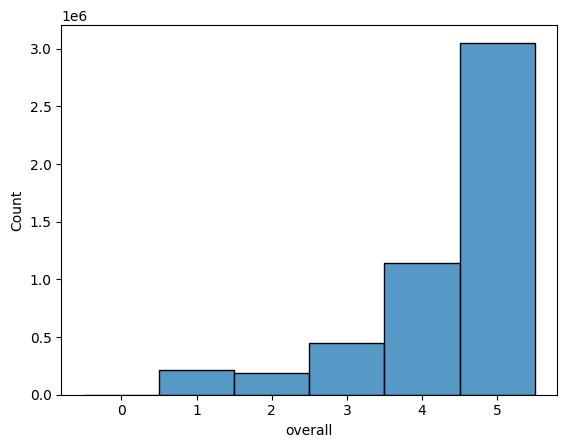

In [47]:
import seaborn as sns

sns.histplot(data=df, x='overall', discrete=True)

/Users/andy/csc5610/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='vote'>

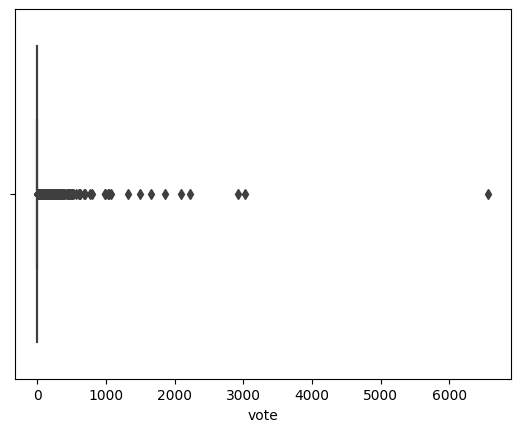

In [50]:
sns.boxplot(data=df, x='vote')

In [54]:
gt_zero = df.query('vote > 0')
lteq_zero = df.query('vote <= 0')

In [58]:
print(f'Votes > 0: {gt_zero.count()}')
print(f'Votes == 0: {lteq_zero.count()}')

Votes > 0: overall           147014
verified          147014
reviewText        147014
summary           147002
unixReviewTime    147014
vote              147014
image             147014
reviewLength      147014
summaryLength     147014
dtype: int64
Votes <= 0: overall           4898146
verified          4898146
reviewText        4898146
summary           4895246
unixReviewTime    4898146
vote              4898146
image             4898146
reviewLength      4898146
summaryLength     4898146
dtype: int64


In [63]:
print(f' Only {(147014 / (147014 + 4898146)) * 100:.02f}% of records have a vote > 1')

 Only 2.91% of records have a vote > 1


In [69]:
df['vote'].max()

6571

/Users/andy/csc5610/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/andy/csc5610/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='vote', ylabel='Count'>

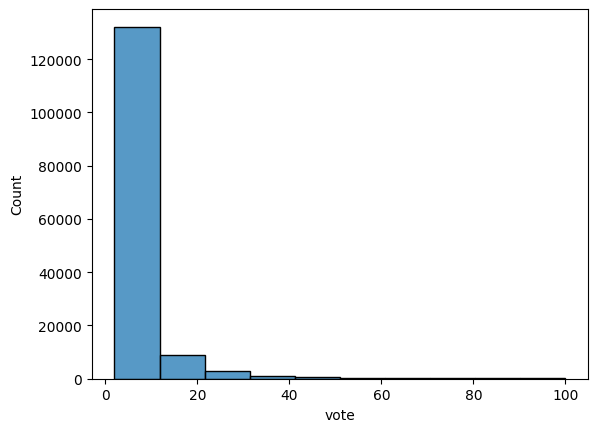

In [73]:
sns.histplot(data=df.query('vote > 0 and vote <= 100'), x='vote', bins=10)

/Users/andy/csc5610/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/andy/csc5610/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='overall', ylabel='Count'>

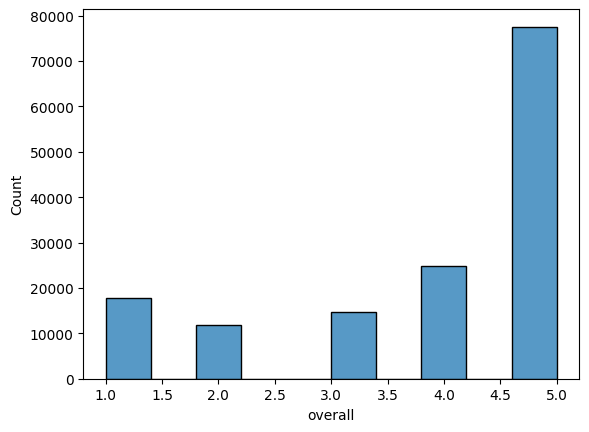

In [76]:
sns.histplot(data=df.query('vote > 0'), x='overall', bins=10)

/Users/andy/csc5610/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/andy/csc5610/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='overall', ylabel='Count'>

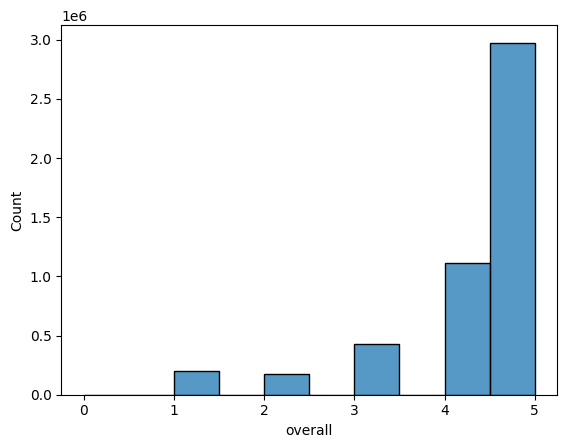

In [77]:
sns.histplot(data=df.query('vote <= 0'), x='overall', bins=10)

reviewing data types

In [86]:
df = df[df['overall'] != 0].dropna()

In [88]:
df['overall'].value_counts()

overall
5    3050493
4    1138959
3     447256
1     214869
2     190670
Name: count, dtype: int64

## Creating BOW

In [89]:
vectorizer = CountVectorizer(stop_words='english')
reviews = df['reviewText'].tolist()
fitted = vectorizer.fit(reviews)
bow = fitted.transform(reviews)

In [111]:
test_vectorizer = CountVectorizer(stop_words='english')
test_review_text = ["great job person", "amazing simple free", "simple free"]
test_bow = test_vectorizer.fit_transform(test_review_text)

In [112]:
test_bow.toarray()

array([[0, 0, 1, 1, 1, 0],
       [1, 1, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 1]])

in the future could make test_size bigger. figure dataset is so big that it doesn't matter.

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Step 1: Prepare the data
X = bow  # Your Bag-of-Words representation
y = df['overall']  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [ ]:
# code from a friends notebook that allows for training in batches
# import numpy as np
# import tqdm
# def pred_pairs(alg, test_data):
#     results = []
#     for i in tqdm(range(0, test_data.shape[0], chunk_size)):
#         batch = test_data[i:i+chunk_size]
#         batch_preds = alg.predict(batch)
#         rows, cols = batch.nonzero()
#         batch_labels_nonzero = np.ravel(batch[rows, cols]).tolist()
#         batch_preds_nonzero = np.ravel(batch_preds[rows, cols]).tolist()
#         y_label = batch_labels_nonzero
#         y_pred = batch_preds_nonzero
#         for y_l, y_p in zip(y_label, y_pred):
#             results.append([y_l, y_p])
#     return np.array(results)

to do log regression makes sparse array dense. this is a problem for large datasets.

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [101]:
# import linear regression
from sklearn.linear_model import LinearRegression
# Step 3: Train a logistic regression model
log_reg = LinearRegression()
log_reg.fit(X_train, y_train)


LinearRegression()

In [102]:
# Step 4: Evaluate the model
accuracy = log_reg.score(X_test, y_test)
print(f"Accuracy of the linear regression model: {accuracy:.2f}")

Accuracy of the linear regression model: 0.14


### Lemmatization

lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.

the count vectorizer uses stemming by default, which is a rudimentary heuristic process that chops off the ends of words. this is not ideal for our use case, so we might use lemmatization instead.

In [ ]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

tf_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents='unicode', 
                                stop_words='english',
                                max_df=0.5,
                                min_df=10)
# ignores the paremter if it occurs in more than 50% of the documents
# ignores the parameter if it occurs in less than 10 documents
tf_vectorizer.fit(reviews)
tf = tf_vectorizer.transform(reviews)